# Домашнее задание

* Получить точность 97.5% на валидации MNIST.
* Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).
* Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

Получить точность 97.5% на валидации MNIST

In [1]:
# Mnist
import torch
import torch.nn as nn # слои
import torch.nn.functional as F # функции ошибки
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
# !q выбираем размер батча
train = get_loader(True, 64)
val = get_loader(False, 64)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [3]:
!ls #folder: <root>/content/

mnist  sample_data


In [4]:
# params
input_dim = 28*28
output_dim = 10
image_width = 28
image_hight = 28

In [5]:
model = nn.Sequential(
    nn.Linear(input_dim, input_dim//2),
    nn.ReLU(),
    nn.Linear(input_dim//2, output_dim),
    nn.LogSoftmax(dim=1)
)

model

Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): ReLU()
  (2): Linear(in_features=392, out_features=10, bias=True)
  (3): LogSoftmax(dim=1)
)

In [6]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        X = X.view(-1, input_dim)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss() # The negative log likelihood loss. It is useful to train a classification problem with C classes.

0.96435 0.9614
0.9797666666666667 0.9734
0.9863666666666666 0.9761
0.99185 0.98
0.9938 0.9791
0.99575 0.979


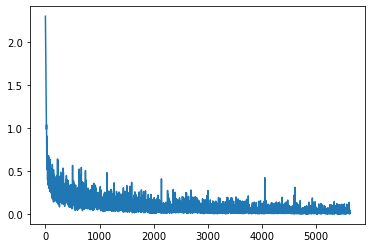

In [8]:
train_losses = []
for epoch in range(6):
    for X, y in train:
        model.train()
        X = X.view(-1, input_dim)  # разгладим картинку в вектор
        
        optimizer.zero_grad()
        
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        
        # убираем информацию о цепочке вычислений
        # градиентов с помощью .item
        train_losses.append(loss.item()) # train_losses 6*938(938 обуч выборок)
        # в батче 32

        optimizer.step()
    
    # eval отключает dropout и batchNorm'ы
    print(accuracy(model.train(), train), accuracy(model.eval(), val))
        
plt.plot(train_losses)
plt.show()

Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).

In [9]:
train.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist
    Split: Train
    StandardTransform
Transform: ToTensor()

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim = 10):
        super().__init__()
        
        self.encode = nn.Sequential(
          # мы хотим перевести картинку в какое-нибудь X-мерное пространство
          nn.Linear(input_dim, input_dim//2),
          nn.ReLU(),
          nn.Linear(input_dim//2, latent_dim)
        )
        
        self.decode = nn.Sequential(
            # а теперь наоборот - из Х-мерного в картинку
            nn.ReLU(),
            nn.Linear(latent_dim, input_dim//2),
            nn.ReLU(),
            nn.Linear(input_dim//2, input_dim),
            nn.Sigmoid()
            # картинки -- это тензоры со значениями от 0 до 1
            # нет особого смысла выводить что-то не из этого промежутка
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder(10)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, input_dim)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0375
epoch 1, loss 0.0273
epoch 2, loss 0.0258
epoch 3, loss 0.0239
epoch 4, loss 0.0226
epoch 5, loss 0.0218
epoch 6, loss 0.0213
epoch 7, loss 0.0209
epoch 8, loss 0.0206
epoch 9, loss 0.0203


In [12]:
import numpy
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [13]:
def get(x):
    return train.dataset[x][0].view(1, input_dim)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(image_width, image_hight)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

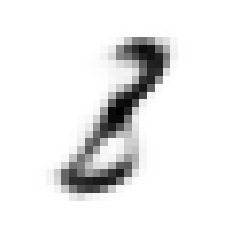

In [14]:
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 30)

Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета). Получить картинку

In [15]:
model = Autoencoder(2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, input_dim)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0549
epoch 1, loss 0.0481
epoch 2, loss 0.0460
epoch 3, loss 0.0448
epoch 4, loss 0.0439
epoch 5, loss 0.0432
epoch 6, loss 0.0426
epoch 7, loss 0.0421
epoch 8, loss 0.0417
epoch 9, loss 0.0414


In [17]:
import numpy as np

# перевод train в латентное 2х мерное пространство
data_latent_dim_x1 = []
data_latent_dim_x2 = []
y_labels = []

for data, y in train:
  data = data.view(-1, input_dim)
  optimizer.zero_grad()
  data_latent_dim_batch = model.encode(data)

  for elem in y:
    y_labels.append(int(elem));

  for elem in data_latent_dim_batch:
    data_latent_dim_x1.append(float(elem[0]))
    data_latent_dim_x2.append(float(elem[1]))

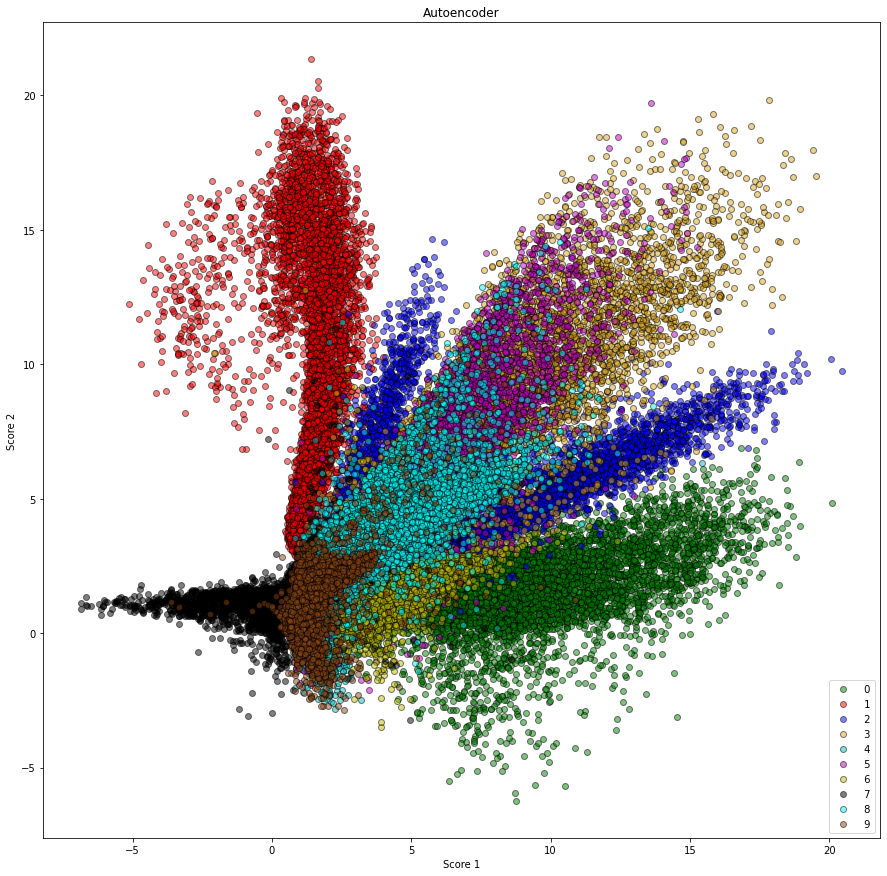

In [19]:
output_size = 10

import matplotlib.pyplot as plt
fig = plt.figure()

dataset_size = len(y_labels)
#print(dataset_size)

colors = ['g', 'r', 'b', 'goldenrod', 'c', 'm', 'y', 'k', 'aqua', 'saddlebrown']

for i in range(0, output_size):
  temp_x = []
  temp_y = []
  for j in range(dataset_size):
    if (y_labels[j] == i):
      temp_x.append(data_latent_dim_x1[j])
      temp_y.append(data_latent_dim_x2[j])

  plt.scatter(temp_x, temp_y, color=colors[i], marker = 'o', alpha=0.5, edgecolors='k', label=' '+str(i))

plt.title("Autoencoder")
plt.xlabel('Score 1')                
plt.ylabel('Score 2')
plt.legend(loc='lower right')

fig.set_size_inches((15,15))
plt.show()

# Выводы:
1. добился точности 98%
2. Реализован морфинг автоэнкодером
3. построен график scatter train датасета